In [19]:
import numpy as np
import cv2
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from prettytable import PrettyTable

from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_curve, auc,f1_score,precision_score,recall_score,precision_recall_curve,matthews_corrcoef
import glob,os,time,pdb,warnings,joblib
warnings.filterwarnings('ignore')

In [20]:
def get_split(samples, labels, test_size):
    return train_test_split(samples, labels,test_size=test_size,random_state=40)

def metric_accuracy(clf, X_train, y_train, X_test, y_test):
    y_train_pred, y_test_pred = clf.predict(X_train), clf.predict(X_test)
    print('Train Accuracy:', accuracy_score(y_train, y_train_pred),'\nTest Accuracy:', accuracy_score(y_test, y_test_pred))

def draw_roc(y_actual, scores, title=''):
    fpr, tpr, thresholds = roc_curve(y_actual, scores, pos_label=1)
    auroc_value = auc(fpr, tpr)

    plt.plot(fpr,tpr, label = 'AUC: '+str(round(auroc_value, 4)))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR = 1-Specificity')
    plt.ylabel("TPR = Recall = Sensitivity")
    plt.title("AUC-ROC Curve: " + title)
    plt.legend(loc = 'lower right')
    plt.savefig(title+'-ROC')
    return auroc_value
    
def metric(y_test, y_pred,scores, title=''):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity, acc, f1, precision, recall, mcc = tn/(tn + fp) ,accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), matthews_corrcoef(y_test, y_pred)
    
    x,metric_list = PrettyTable(), []
    
    x.field_names = ["Evaluation Metric", "Score"]; 
    x.add_row(["Accuracy", round(acc, 4)]); metric_list.append(["Accuracy",round(acc, 4)])
    x.add_row(["F1-score", round(f1, 4)]); metric_list.append(['F1-score',round(f1, 4)])
    x.add_row(["Precision", round(precision, 4)]); metric_list.append(['Precision', round(precision, 4)])
    x.add_row(["Recall", round(recall, 4)]); metric_list.append(["Recall", round(recall, 4)])
    x.add_row(["Specificity", round(specificity, 4)]); metric_list.append(["Specificity", round(specificity, 4)])
    x.add_row(["MCC", round(mcc, 4)]); metric_list.append(["MCC", round(mcc, 4)])
    
    auroc_value = draw_roc(y_test,scores, title)
    x.add_row(["AUROC value", round(auroc_value, 4)]); metric_list.append(["AUROC value", round(auroc_value, 4)])
    
    print(x);plt.show()
    print('--------------------------------------------------------------\n\n\n')
    return metric_list

In [5]:
path = 'dataset/PlantVillage/train'
X_files, y_class=[], []
class_number = 0
for dire in glob.glob(os.path.join(path, '*')):
    print(dire)
    for filename in glob.glob(os.path.join(dire, '*')):
        if('.info' in filename):
            continue
        st=filename.split('\\')
        s=st[0]+'/'+st[1]+'/'+st[2]
        X_files.append(s)
#         y_class.append(dire)
        y_class.append(class_number)
    class_number +=1
print(len(X_files),len(y_class))

dataset/PlantVillage/train\Apple___Apple_scab
dataset/PlantVillage/train\Apple___Black_rot
dataset/PlantVillage/train\Apple___Cedar_apple_rust
dataset/PlantVillage/train\Apple___healthy
dataset/PlantVillage/train\background
dataset/PlantVillage/train\Blueberry___healthy
dataset/PlantVillage/train\Cherry_(including_sour)___healthy
dataset/PlantVillage/train\Cherry_(including_sour)___Powdery_mildew
dataset/PlantVillage/train\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
dataset/PlantVillage/train\Corn_(maize)___Common_rust_
dataset/PlantVillage/train\Corn_(maize)___healthy
dataset/PlantVillage/train\Corn_(maize)___Northern_Leaf_Blight
dataset/PlantVillage/train\Grape___Black_rot
dataset/PlantVillage/train\Grape___Esca_(Black_Measles)
dataset/PlantVillage/train\Grape___healthy
dataset/PlantVillage/train\Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
dataset/PlantVillage/train\Orange___Haunglongbing_(Citrus_greening)
dataset/PlantVillage/train\Peach___Bacterial_spot
dataset/PlantVillage/t

In [7]:
X_data = []
for name in X_files:
    img = cv2.imread(r''+name,cv2.COLOR_BGR2GRAY) #converting to gray scale img
    img_resized = cv2.resize(img,(28,28),interpolation = cv2.INTER_AREA)
    X_data.append(img_resized)
#     X_data.append(img)

X_ravel = []
for i in X_data:
    ravel = i.ravel()
    X_ravel.append(ravel)
X_ravel = np.asarray(X_ravel)

In [8]:
X_ravel.shape

(44016, 2352)

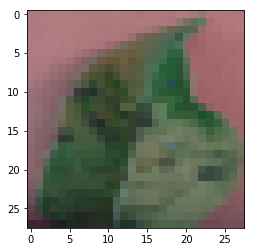

In [9]:
plt.imshow(X_data[0])

In [10]:
test_size=0.2
X_scale = scale(X_ravel)
X_train_scale, X_test_scale, y_train, y_test = get_split(X_scale,y_class,test_size)

len(X_train_scale), len(X_test_scale) , len(y_train), len(y_test)

(35212, 8804, 35212, 8804)

### SVM

In [23]:
model = SVC(kernel='rbf',probability=True)

model.fit(X_train_scale,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Metrics

In [ ]:
joblib.dump(model, 'svm.sav')

In [25]:
y_pred_train = model.predict(X_train_scale)

accuracy_score(y_pred_train,y_train)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_pred_train, y_train))

### Metrics

In [ ]:
y_train_pred, y_test_pred = model.predict(X_train_scale), model.predict(X_test_scale)

In [ ]:
train_scores, test_scores = model.predict_proba(X_train_scale)[:,1], model.predict_proba(X_test_scale)[:,1]

In [ ]:
print('SVM(kernel=RBF) classifier')
linear_svm_metric_list_train, linear_metric_list_test = metric(y_train, y_train_pred, train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, y_test_pred, test_scores, 'SVM (Test metrics)')

### Test

In [13]:
y_pred = model.predict(X_test_scale)

accuracy_score(y_pred,y_test)

0.8316375968992248

In [16]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       190
           1       0.91      0.89      0.90       307
           2       0.91      0.85      0.88       195
           3       0.40      0.91      0.56        11
           4       0.74      0.76      0.75       172
           5       0.91      0.85      0.88       462
           6       0.43      0.63      0.51       137
           7       0.98      0.94      0.96       343
           8       0.77      0.74      0.76       400
           9       0.76      0.83      0.79       185
          10       0.78      0.76      0.77       380
          11       0.88      0.80      0.84       366
          12       0.80      0.82      0.81       271
          13       0.72      0.81      0.76        63
          14       0.94      0.92      0.93       646

   micro avg       0.83      0.83      0.83      4128
   macro avg       0.78      0.82      0.79      4128
weighted avg       0.84   

In [19]:
print(precision_recall_fscore_support(y_test, y_pred))

(array([0.78947368, 0.89250814, 0.84615385, 0.90909091, 0.75581395,
       0.85281385, 0.62773723, 0.94169096, 0.7425    , 0.83243243,
       0.76052632, 0.80327869, 0.81549815, 0.80952381, 0.92105263]), array([0.71090047, 0.91333333, 0.90659341, 0.4       , 0.73863636,
       0.91203704, 0.42574257, 0.97878788, 0.7734375 , 0.75862069,
       0.78108108, 0.88288288, 0.79783394, 0.71830986, 0.9414557 ]), array([0.74812968, 0.90280066, 0.87533156, 0.55555556, 0.74712644,
       0.88143177, 0.50737463, 0.95988113, 0.75765306, 0.79381443,
       0.77066667, 0.84120172, 0.80656934, 0.76119403, 0.93114241]), array([211, 300, 182,  25, 176, 432, 202, 330, 384, 203, 370, 333, 277,
        71, 632], dtype=int64))


In [23]:
print(precision_score(y_test, y_pred,average=None))

[0.78947368 0.89250814 0.84615385 0.90909091 0.75581395 0.85281385
 0.62773723 0.94169096 0.7425     0.83243243 0.76052632 0.80327869
 0.81549815 0.80952381 0.92105263]


In [24]:
print(recall_score(y_test, y_pred,average=None))

[0.71090047 0.91333333 0.90659341 0.4        0.73863636 0.91203704
 0.42574257 0.97878788 0.7734375  0.75862069 0.78108108 0.88288288
 0.79783394 0.71830986 0.9414557 ]
